In [1]:
from deepsudoku import REPO_PATH, DIFFICULTIES
import os
os.chdir(REPO_PATH)

import tensorflow as tf
import numpy as np
from deepsudoku.reinforcement_learning.ppo import *

import gymnasium as gym
from deepsudoku.verify_sudoku import *

2023-08-24 12:33:51.859575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sudoku Environment avaible at gymnasium as 'Sudoku-v0'.


In [2]:
size = 3
sq_size = np.square(size)

envs = PPO_MultiDiscrete_Environment_Wrapper('Sudoku-v1', 5, size=size)

sudoku_input_shape = (sq_size, sq_size)

In [3]:
# Create models

# Implementation Detail 2: Orthogonal Initialization of hidden weights and constant initialization of biases and output weights
# Biases seem to be 0 by default in Keras
hidden_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=np.sqrt(2))
pol_out_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=0.01)
val_out_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=1)

def create_policy_model():
    inputs = tf.keras.Input(shape=sudoku_input_shape)
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation="relu", kernel_initializer=hidden_ortho_init())(x)
    x = tf.keras.layers.Dense(128, activation="relu", kernel_initializer=hidden_ortho_init())(x)
    x = [tf.keras.layers.Dense(9, activation="log_softmax", kernel_initializer=pol_out_ortho_init())(x) for i in range(3)]
    x = tf.keras.layers.Concatenate()(x)
    outputs = tf.keras.layers.Reshape((3,9))(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pi")
    return model

def create_value_function_model():
    inputs = tf.keras.Input(shape=sudoku_input_shape)
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(32, activation="relu", kernel_initializer=hidden_ortho_init())(x)
    #x = tf.keras.layers.Dense(32, activation="relu", kernel_initializer=hidden_ortho_init())(x)
    outputs = tf.keras.layers.Dense(1, activation="linear", kernel_initializer=val_out_ortho_init())(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="V")
    return model


In [4]:
pi, V = PPO(envs, create_policy_model(), create_value_function_model(), TRAIN_EPOCHS = 1000, LEARNING_RATE_DECAY_PER_EPOCH = 0, LEARNING_RATE_START=0.001)

2023-08-24 12:33:55.644268: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


epoch:  0  ; KL:  0  ; LR:  0.001  ; MR:  0
Collection
Tapework
epoch:  1  ; KL:  0.14415678  ; LR:  0.001  ; MR:  -0.866
Collection
Tapework
epoch:  2  ; KL:  0.07456758  ; LR:  0.001  ; MR:  -0.866
Collection
Tapework
epoch:  3  ; KL:  0.013215714  ; LR:  0.001  ; MR:  -0.804
Collection
Tapework
epoch:  4  ; KL:  0.0073323664  ; LR:  0.001  ; MR:  -0.828
Collection
Tapework
epoch:  5  ; KL:  0.0054996843  ; LR:  0.001  ; MR:  -0.78
Collection
Tapework
epoch:  6  ; KL:  0.007977223  ; LR:  0.001  ; MR:  -0.826
Collection
Tapework
epoch:  7  ; KL:  0.003932683  ; LR:  0.001  ; MR:  -0.85
Collection
Tapework
epoch:  8  ; KL:  0.0060280478  ; LR:  0.001  ; MR:  -0.886
Collection
Tapework
epoch:  9  ; KL:  0.017728359  ; LR:  0.001  ; MR:  -0.822
Collection
Tapework
epoch:  10  ; KL:  0.024664579  ; LR:  0.001  ; MR:  -0.818
Collection
Tapework
epoch:  11  ; KL:  0.006249193  ; LR:  0.001  ; MR:  -0.824
Collection
Tapework
epoch:  12  ; KL:  0.005405206  ; LR:  0.001  ; MR:  -0.838
Collec

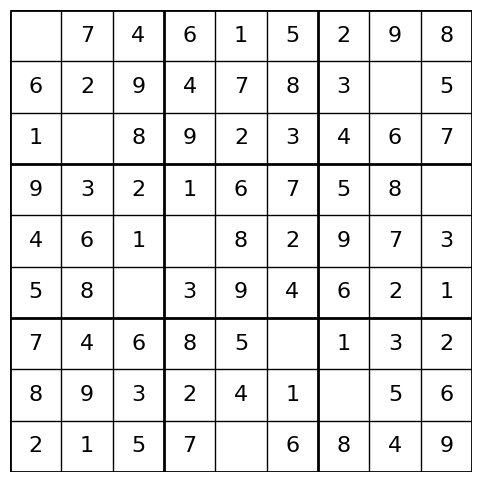

In [17]:

test_env = gym.make('Sudoku-v1', render_mode='human', size=size)
#test_env = gym.make('CartPole-v1', render_mode='human')
obs, inf = test_env.reset()
test_env.render()

tf.Tensor(
[[[-5.8649907  -3.6209269  -2.0680697  -7.3397145  -0.7801835
   -3.8999949  -1.3187032  -2.5704362  -3.8738463 ]
  [-2.986763   -7.0560184  -3.9652586  -0.42089784 -1.5404791
   -3.9418492  -3.9114628  -3.9757404  -7.131288  ]
  [-6.199985   -7.117755   -0.09967381 -3.9588506  -7.418715
   -4.3360496  -3.3514302  -4.3113933  -4.5277314 ]]], shape=(1, 3, 9), dtype=float32)
[4, 3, 2] False 0.5


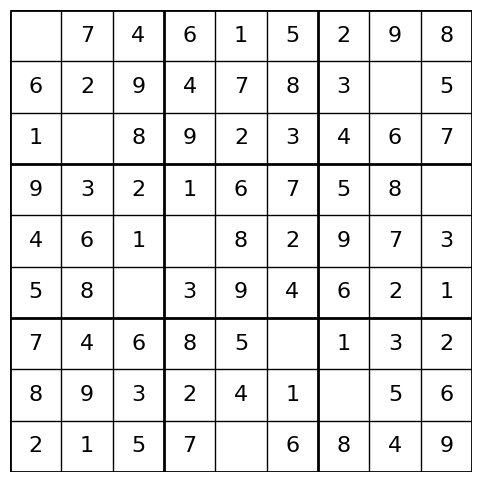

In [18]:
qs = pi(tf.expand_dims(obs, 0))
print(qs)
act = [np.argmax(subspace) for subspace in qs[0]]
obs, reward, terminated, _, _ = test_env.step(act)
print(act, terminated, reward)
test_env.render()